## Simulación

La forma de interpretar la simulación es la siguiente:
Imaginemos que estamos en el día de las elecciones y nos van llegando datos de condados (equivalentes a dataset de train) y queremos hacer un forecast de cómo van a acabar las elecciones, es decir, hacer un forecast de los condados que todavía no tenemos los datos (test). En ese sentido, podríamos hacer un modelo con los datos que sí tenemos (train) y predecir los condados que todavía no tenemos (test). Y así podemos repetir el proceso N veces y crear una simulación.

In [144]:
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import json
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [128]:
def load_seats_data(path, state_to_code):
    # Cargar datos
    seats_data = pd.read_csv(path, header=0, sep=",")

    # Seleccionar las primeras tres columnas y las columnas que contienen "2019"
    seats_data = seats_data.iloc[:, [0, 1]]

    # Renombrar columnas
    seats_data.columns = ["state", "electoral_votes_number"]

    # Añadir District of Columbia pues no aparece
    new_row = pd.DataFrame({
        'state': ['District of Columbia'],
        'electoral_votes_number': [3]
    })

    # Añadir la nueva fila al DataFrame utilizando pd.concat
    seats_data = pd.concat([seats_data, new_row], ignore_index=True)

    
    seats_data["state_code"] = seats_data['state'].map(state_to_code)

    return seats_data

In [129]:
# Cargar datos
data = read_csv("data/final_data.csv")
columns_to_drop = ['Total_2020', 'Other_2020', 'Winner_2020', "Biden_2020"]  # Nombres de las columnas a eliminar
data_sim = data.drop(columns=columns_to_drop)

# Cargar codigo de estados
with open("data/state_to_code.json", "r") as file:
    state_to_code = json.load(file)


# Cargar datos de escaños por estado
seats_data = load_seats_data("data/seats2020.csv", state_to_code)

# Cargar datos de state, county, fips
state_fips_county = read_csv('data/state_fips_county.csv')
state_names = state_fips_county['state']
fips_codes = state_fips_county['fips']
county_names = state_fips_county['county']

In [ ]:
user_input = input("Escribe tu nombre: ")
print(f"Hola, {user_input}")

In [130]:
n_sim = 100

# Inicializar un DataFrame para guardar los resultados de las simulaciones
simulation_results = pd.DataFrame(columns=['Biden_Pred', 'Trump_Pred', 'Biden', 'Trump'])

# Inicializar un DataFrame para acumular los resultados por estado
accumulated_pred_state = pd.DataFrame()

for i in range(0, n_sim):

    print(f"Simulation {i}")

    ## Data splitting
    # Quitar la columna objetivo ('Perc_Biden_2020') del conjunto de datos
    X = data_sim.drop(columns=["Perc_Biden_2020"])  # Características (sin la columna objetivo)
    y = data_sim["Perc_Biden_2020"]  # Columna objetivo

    # Dividir los datos en 80% para train y 20% para test (cada sim es distinto)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    ## Models
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    pred_lr = lr_model.predict(X_test)

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=i)
    rf_model.fit(X_train, y_train)
    pred_rf = rf_model.predict(X_test)

    # KNN
    knn_model = KNeighborsRegressor(n_neighbors=5)  # Puedes ajustar el número de vecinos
    knn_model.fit(X_train, y_train)
    pred_knn = knn_model.predict(X_test)

    # Predicciones combinadas
    predictions = (pred_lr + pred_rf + pred_knn) / 3  # Promedio de predicciones de los tres modelos

    # Todos los votos por condado, pero usando predicciones
    perc_biden_pred = data['Perc_Biden_2020'].copy()
    perc_biden_pred.iloc[X_test.index] = predictions

    # Agrupar por estado para calcular las predicciones por estado
    df_pred = pd.DataFrame({'Votes_Biden_2020': perc_biden_pred * data['Total_2020'], 
                            'Votes_Trump_2020': (1 - perc_biden_pred - data["Perc_Other_2020"]) * data['Total_2020'], 
                            'Votes_Total_2020': data['Total_2020'], 
                            'state': state_names,
                            'county': county_names,
                            'fips': fips_codes})
    df_pred_state = df_pred.groupby('state').agg(Votes_Biden_2020=('Votes_Biden_2020', 'sum'), 
                                                 Votes_Trump_2020=('Votes_Trump_2020', 'sum'),
                                                 Votes_Total_2020=('Votes_Total_2020', 'sum'))
    
    df_actual = pd.DataFrame({'Votes_Biden_2020': data['Biden_2020'], 
                            'Votes_Trump_2020': data['Total_2020'] - data['Biden_2020'] - data['Other_2020'], 
                            'Votes_Total_2020': data['Total_2020'], 
                            'state': state_names,
                            'county': county_names,
                            'fips': fips_codes})
    df_actual_state = df_actual.groupby('state').agg(Votes_Biden_2020=('Votes_Biden_2020', 'sum'), 
                                                     Votes_Trump_2020=('Votes_Trump_2020', 'sum'),
                                                     Votes_Total_2020=('Votes_Total_2020', 'sum'))
    
    # Calcular porcentaje de cada candidato en el estado
    df_pred_state["Perc_Biden_2020"] = df_pred_state["Votes_Biden_2020"] / df_pred_state["Votes_Total_2020"]
    df_pred_state["Perc_Trump_2020"] = df_pred_state["Votes_Trump_2020"] / df_pred_state["Votes_Total_2020"]

    df_actual_state["Perc_Biden_2020"] = df_actual_state["Votes_Biden_2020"] / df_actual_state["Votes_Total_2020"]
    df_actual_state["Perc_Trump_2020"] = df_actual_state["Votes_Trump_2020"] / df_actual_state["Votes_Total_2020"]

    # Acumular los resultados de cada simulación
    if accumulated_pred_state.empty:
        accumulated_pred_state = df_pred_state.copy()  # Primera iteración, simplemente copiamos los datos
    else:
        accumulated_pred_state['Votes_Biden_2020'] += df_pred_state['Votes_Biden_2020']
        accumulated_pred_state['Votes_Trump_2020'] += df_pred_state['Votes_Trump_2020']
        accumulated_pred_state['Votes_Total_2020'] += df_pred_state['Votes_Total_2020']
        accumulated_pred_state['Perc_Biden_2020'] += df_pred_state['Perc_Biden_2020']
        accumulated_pred_state['Perc_Trump_2020'] += df_pred_state['Perc_Trump_2020']

    # Predicción y ganadores
    df_pred_state['Winner_2020'] = np.where(df_pred_state['Perc_Biden_2020'] < df_pred_state['Perc_Trump_2020'], 'Trump', 'Biden')
    df_actual_state['Winner_2020'] = np.where(df_actual_state['Perc_Biden_2020'] < df_actual_state['Perc_Trump_2020'], 'Trump', 'Biden')
    

    # Añadir votos electorales (escaños) a cada estado
    full_df_pred_state = pd.merge(seats_data, df_pred_state, how='inner', on=["state"])
    full_df_actual_state = pd.merge(seats_data, df_actual_state, how='inner', on=["state"])



    # Agrupar por estado y sumar los votos
    df_pred_winner = full_df_pred_state.groupby("Winner_2020").agg({
        "electoral_votes_number": "sum",  # Sumar los votos electorales de cada candidato
    }).reset_index()

    df_pred_winner.loc[df_pred_winner['Winner_2020'] == 'Trump', 'electoral_votes_number'] += 3 # Añadir 3 al número de votos electorales de Trump por Alaska


    df_actual_winner = full_df_actual_state.groupby("Winner_2020").agg({
        "electoral_votes_number": "sum",  # Sumar los votos electorales de cada candidato
    }).reset_index()

    df_actual_winner.loc[df_actual_winner['Winner_2020'] == 'Trump', 'electoral_votes_number'] += 3 # Añadir 3 al número de votos electorales de Trump por Alaska


    # Crear un nuevo DataFrame con los resultados de esta simulación
    new_row = pd.DataFrame({
        'Biden_Pred': [df_pred_winner.loc[df_pred_winner['Winner_2020'] == 'Biden', 'electoral_votes_number'].values[0]],
        'Trump_Pred': [df_pred_winner.loc[df_pred_winner['Winner_2020'] == 'Trump', 'electoral_votes_number'].values[0]],
        'Biden': [df_actual_winner.loc[df_actual_winner['Winner_2020'] == 'Biden', 'electoral_votes_number'].values[0]],
        'Trump': [df_actual_winner.loc[df_actual_winner['Winner_2020'] == 'Trump', 'electoral_votes_number'].values[0]],
        'Winner': ['Biden' if df_pred_winner.loc[df_pred_winner['Winner_2020'] == 'Biden', 'electoral_votes_number'].values[0] > df_pred_winner.loc[df_pred_winner['Winner_2020'] == 'Trump', 'electoral_votes_number'].values[0] else 'Trump']
    })

    # Usar concat para añadir la nueva fila
    simulation_results = pd.concat([simulation_results, new_row], ignore_index=True)

# Después de todas las simulaciones, calcular la media
accumulated_pred_state['Votes_Biden_2020'] /= n_sim
accumulated_pred_state['Votes_Trump_2020'] /= n_sim
accumulated_pred_state['Votes_Total_2020'] /= n_sim
accumulated_pred_state['Perc_Biden_2020'] /= n_sim
accumulated_pred_state['Perc_Trump_2020'] /= n_sim


In [131]:
simulation_results

,Biden_Pred,Trump_Pred,Biden,Trump,Winner
0,296,242,306,232,Biden
1,292,246,306,232,Biden
2,290,248,306,232,Biden
3,280,258,306,232,Biden
4,278,260,306,232,Biden
...,...,...,...,...,...
95,280,258,306,232,Biden
96,324,214,306,232,Biden
97,296,242,306,232,Biden
98,280,258,306,232,Biden


In [139]:
# Añadir la columna "Winner" basado en los porcentajes predichos de Biden y Trump
accumulated_pred_state['Winner'] = np.where(
    accumulated_pred_state['Perc_Biden_2020'] >= accumulated_pred_state['Perc_Trump_2020'], 'Biden', 'Trump'
)

# Añadir los códigos de los estados usando el diccionario state_to_code
accumulated_pred_state['state_code'] = accumulated_pred_state.index.map(state_to_code)

# Añadir diferencia entre Biden y Trump
accumulated_pred_state['Difference'] = (accumulated_pred_state['Perc_Biden_2020'] - accumulated_pred_state['Perc_Trump_2020']) * 100


# Definir las condiciones y los valores a asignar
conditions = [
    accumulated_pred_state["Difference"] > 10,
    accumulated_pred_state["Difference"].between(3, 10),
    accumulated_pred_state["Difference"].between(-3, 3),
    accumulated_pred_state["Difference"].between(-10, -3),
    accumulated_pred_state["Difference"] < -10
]

choices = [
    "Safe Biden",
    "Likely Biden",
    "Toss-Up",
    "Likely Trump",
    "Safe Trump"
]

# Usar np.select para asignar el "Status" basado en las condiciones, con un valor por defecto "Unknown"
accumulated_pred_state["Status"] = np.select(conditions, choices, default="Unknown")


# Mostrar el DataFrame
accumulated_pred_state


,Votes_Biden_2020,Votes_Trump_2020,Votes_Total_2020,Perc_Biden_2020,Perc_Trump_2020,Winner,state_code,Difference,Status
state,,,,,,,,,
Alabama,8.758078e+05,1.415008e+06,2323304.0,0.376966,0.609050,Trump,AL,-23.208349,Safe Trump
Arizona,1.696658e+06,1.637171e+06,3387326.0,0.500884,0.483323,Biden,AZ,1.756159,Toss-Up
Arkansas,4.300396e+05,7.545394e+05,1219069.0,0.352761,0.618947,Trump,AR,-26.618656,Safe Trump
California,1.114402e+07,5.971710e+06,17495906.0,0.636950,0.341320,Biden,CA,29.562945,Safe Biden
Colorado,1.784374e+06,1.384585e+06,3256953.0,0.547866,0.425117,Biden,CO,12.274914,Safe Biden
Connecticut,1.072796e+06,7.231751e+05,1824280.0,0.588065,0.396417,Biden,CT,19.164869,Safe Biden
Delaware,2.905690e+05,2.063020e+05,504010.0,0.576514,0.409321,Biden,DE,16.719299,Safe Biden
District of Columbia,3.098255e+05,2.608354e+04,344356.0,0.899724,0.075746,Biden,DC,82.397847,Safe Biden
Florida,5.372409e+06,5.593367e+06,11067456.0,0.485424,0.505389,Trump,FL,-1.996468,Toss-Up


## Gráficos

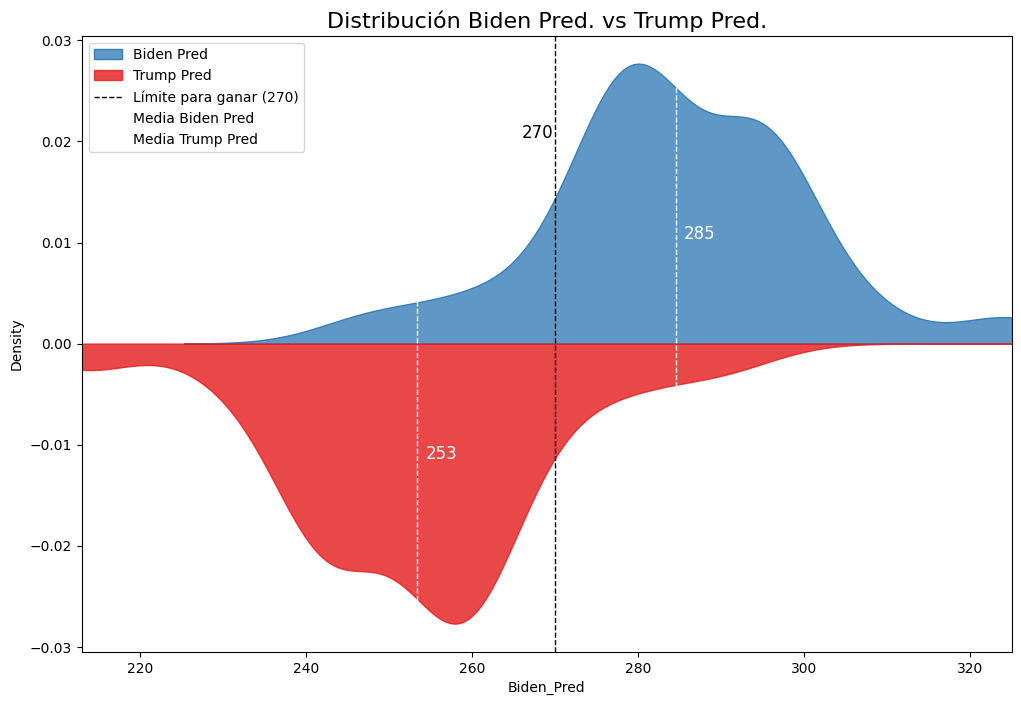

In [140]:
# Asegurarse de que los valores de Trump_Pred y Biden_Pred sean numéricos
simulation_results['Trump_Pred'] = pd.to_numeric(simulation_results['Trump_Pred'], errors='coerce')
simulation_results['Biden_Pred'] = pd.to_numeric(simulation_results['Biden_Pred'], errors='coerce')

# Eliminar cualquier fila con valores NaN (si es necesario)
simulation_results = simulation_results.dropna(subset=['Trump_Pred', 'Biden_Pred'])

# Crear un gráfico de densidad para las predicciones de Biden y Trump
plt.figure(figsize=(12, 8))

# Gráfico de densidad para Biden (positivo)
sns.kdeplot(simulation_results['Biden_Pred'], color="#377eb8", fill=True, alpha=0.8, label="Biden Pred")

# Crear la densidad para Trump usando gaussian_kde
density_trump = gaussian_kde(simulation_results['Trump_Pred'])
x_vals = np.linspace(min(simulation_results['Trump_Pred']), max(simulation_results['Biden_Pred']), 1000)
y_vals = density_trump(x_vals)

# Graficar la densidad de Trump invertida
plt.fill_between(x_vals, -y_vals, color="#e41a1c", alpha=0.8, label="Trump Pred")

# Línea vertical en 270 votos
plt.axvline(x=270, color="black", linestyle="--", linewidth=1, label="Límite para ganar (270)")
plt.text(270-4, 0.02, '270', color="black", verticalalignment='bottom', fontsize=12)  # Añadir el valor '270' dentro del gráfico

# Línea vertical para la media de las predicciones de Biden
plt.axvline(x=np.mean(simulation_results['Biden_Pred']), color="white", linestyle="--", linewidth=1, label="Media Biden Pred")
mean_biden = np.mean(simulation_results['Biden_Pred'])
plt.text(mean_biden + 1, 0.01, f'{mean_biden:.0f}', color="white", verticalalignment='bottom', fontsize=12)  # Añadir el valor de la media de Biden

# Línea vertical para la media de las predicciones de Trump
plt.axvline(x=np.mean(simulation_results['Trump_Pred']), color="white", linestyle="--", linewidth=1, label="Media Trump Pred")
mean_trump = np.mean(simulation_results['Trump_Pred'])
plt.text(mean_trump + 1, -0.01, f'{mean_trump:.0f}', color="white", verticalalignment='top', fontsize=12)  # Añadir el valor de la media de Trump



# Ajustar el eje Y para que sea simétrico
plt.ylim(-1.1 * max(y_vals), 1.1 * max(y_vals))

# Ajustar el eje X para ver más a la izquierda
plt.xlim(min(simulation_results['Trump_Pred']), max(simulation_results['Biden_Pred']))

# Añadir título
plt.title("Distribución Biden Pred. vs Trump Pred.", fontsize=16)

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


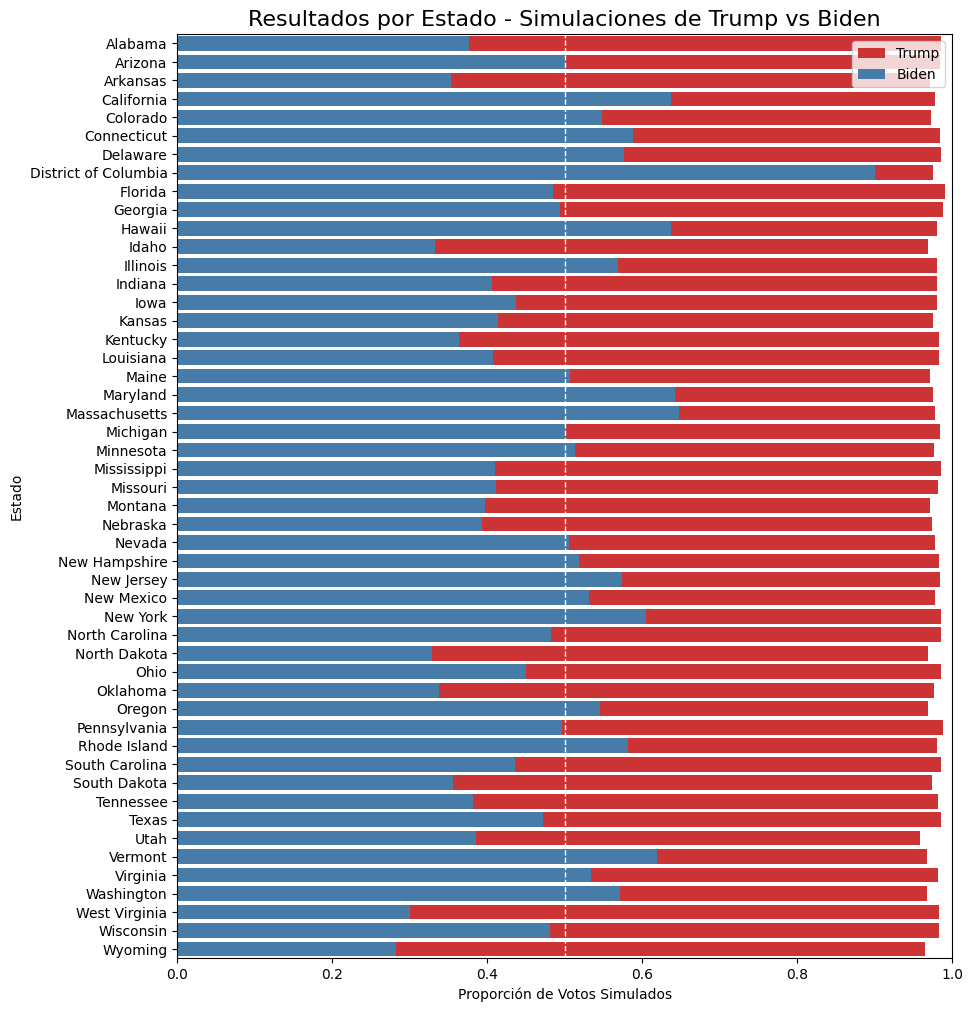

In [141]:
# Ordenar los estados por orden alfabético
accumulated_pred_state_sorted = accumulated_pred_state.sort_values('state', ascending=False)

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 12))

# Primero, graficar la barra de Trump
sns.barplot(x=accumulated_pred_state_sorted['Perc_Biden_2020'] + accumulated_pred_state_sorted['Perc_Trump_2020'], 
            y='state', data=accumulated_pred_state_sorted, color="#e41a1c", label="Trump")

# Luego, graficar la barra de Biden encima de Trump
sns.barplot(x='Perc_Biden_2020', y='state', data=accumulated_pred_state_sorted, color="#377eb8", label="Biden")

# Añadir una línea vertical en el 50%
plt.axvline(x=0.50, color="white", linestyle="--", linewidth=1)

# Añadir leyenda
plt.legend(loc='best')

# Invertir el eje Y para que los estados se vean de arriba hacia abajo
plt.gca().invert_yaxis()

# Añadir etiquetas y título
plt.title('Resultados por Estado - Simulaciones de Trump vs Biden', fontsize=16)
plt.xlabel('Proporción de Votos Simulados')
plt.ylabel('Estado')

# Ajustar el eje X para que las barras lleguen al 100%
plt.xlim(0, 1)

# Mostrar el gráfico
plt.show()

In [142]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(accumulated_pred_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Winner',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        'Perc_Biden_2020': ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        'Perc_Trump_2020': ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'Biden': '#377eb8', 'Trump': '#e41a1c'},  # Colores asignados
                    labels={'Winner': 'Ganador 2020'},  # Etiqueta para la barra de color
                    title="Resultado Medio de las Simulaciones - Elecciones Presidenciales 2020"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()


In [143]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(accumulated_pred_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Status',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        'Perc_Biden_2020': ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        'Perc_Trump_2020': ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'Safe Biden': '#377eb8', 
                                        'Likely Biden': '#a3cef1', 
                                        'Toss-Up': '#b6b164', 
                                        'Likely Trump': '#d56062', 
                                        'Safe Trump': '#e41a1c'},
                    labels={'Winner': 'Ganador 2020'},  # Etiqueta para la barra de color
                    title="Status de los Estados en las Simulaciones - Elecciones Presidenciales 2020"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()
